# Computer Vision Projects

## Mosaicing and image stiching

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

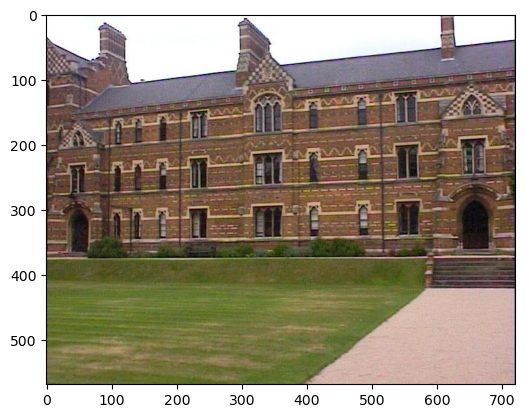

In [2]:
img_a = cv2.imread('./images/keble_a.jpg')
img_rgb_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_a)

In [3]:
def get_the_N_information(image, n=200):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    print('The number of keypoints with sift is {}'.format(len(keypoints)))

    # Convierte los keypoints en un array de NumPy para el valor de respuesta
    responses = np.array([kp.response for kp in keypoints])

    # Ordena los índices de los keypoints basados en la respuesta
    indices = np.argsort(responses)[::-1]

    # Reordena los keypoints usando los índices ordenados
    keypoints_sorted = [keypoints[i] for i in indices][:200]
    descriptors_sorted = descriptors[indices][:200]

    img_kp = cv2.drawKeypoints(image, keypoints_sorted, None, color=(255,0,0))
    plt.imshow(img_kp)
    return keypoints_sorted, descriptors_sorted

The number of keypoints with sift is 4055


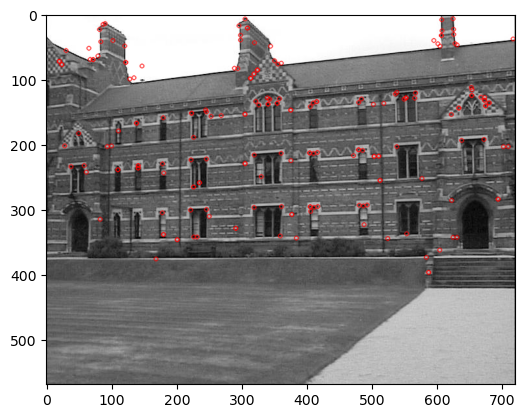

In [4]:
img_gs_a = cv2.imread('./images/keble_a.jpg', cv2.IMREAD_GRAYSCALE)
kp_a, d_a = get_the_N_information(img_gs_a)

The number of keypoints with sift is 4187


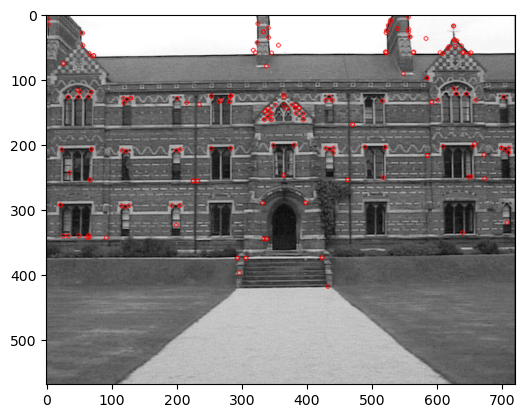

In [5]:
img_gs_b = cv2.imread('./images/keble_b.jpg', cv2.IMREAD_GRAYSCALE)
kp_b, d_b = get_the_N_information(img_gs_b)

In [6]:
def create_distance_matrix(descriptor_1, descriptor_2):
    width = descriptor_1.shape[0]
    distance = np.zeros((width, width))
    for i in range(width):
        one_row_matrix = np.reshape(descriptor_1[i], (1, -1)).repeat(width, 0)
        dist = np.sqrt(np.sum((one_row_matrix - descriptor_2) ** 2, 1))
        distance[i] = dist
    return distance

def NN_and_cross_validation(distance_matrix):
    size = distance_matrix.shape[0]
    threshold = .75
    correspondances = []
    for i in range(size):
        line = distance_matrix[i]
        # Obtein the 1NN and the 2NN
        first_and_second = np.sort(line)[:2]
        # Apply 1NN/2NN threshold
        if (first_and_second[0] / first_and_second[1]) < threshold:
            ind = np.argmin(line)
            # Apply cross validation check
            if np.argmin(distance_matrix[:, ind]) == i:
                # correspondances.append([i, ind])
                match = cv2.DMatch(i, ind, first_and_second[0])
                correspondances.append(match)
    return correspondances

def create_correspondances(descriptor_1, descriptor_2):
    dis = create_distance_matrix(descriptor_1, descriptor_2)
    corr = NN_and_cross_validation(dis)
    return corr

There are 53 correspondances out of 200.


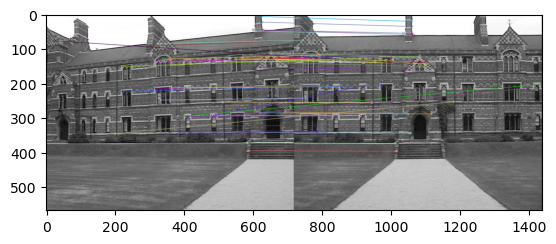

(<matplotlib.image.AxesImage at 0x148187fe0>, None)

In [7]:
# Create the correspondances
correspondances = create_correspondances(d_a, d_b)
print('There are {} correspondances out of 200.'.format(len(correspondances)))

# Show the matches
img3 = cv2.drawMatches(img_gs_a, kp_a, img_gs_b, kp_b, correspondances, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

The number of keypoints with sift is 4014
There are 57 correspondances out of 200.


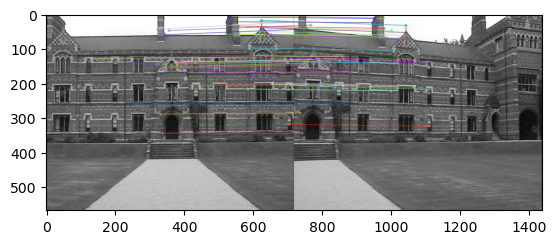

(<matplotlib.image.AxesImage at 0x148187b90>, None)

In [8]:
# Open the images
img_gs_c = cv2.imread('./images/keble_c.jpg', cv2.IMREAD_GRAYSCALE)
kp_c, d_c = get_the_N_information(img_gs_c)

# Create the correspondances
correspondances2 = create_correspondances(d_b, d_c)
print('There are {} correspondances out of 200.'.format(len(correspondances2)))

# Show the matches
matches2 = cv2.drawMatches(img_gs_b, kp_b, img_gs_c, kp_c, correspondances2, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(matches2),plt.show()

In [73]:
# Now we will estimate the homography matrix.
# To do so, first we are going to normalize the points.
def get_points(matches, kp1, kp2):
    indexes1 = np.array([match.queryIdx for match in matches])
    indexes2 = np.array([match.trainIdx for match in matches])

    points1 = np.array([kp1[ind].pt for ind in indexes1])
    points2 = np.array([kp2[ind].pt for ind in indexes2])
    return points1, points2

def normalize_points(points):
    centroid = np.mean(points, axis=0)
    shifted_points = points - centroid
    
    dist = np.linalg.norm(shifted_points, axis=1)
    avg_dist = np.mean(dist)

    scale = np.sqrt(2) / avg_dist

    T = np.array([[scale, 0, -scale * centroid[0]],
                [0, scale, -scale * centroid[1]],
                [0, 0, 1]])
    
    points_normalized = np.dot(T, np.vstack((points.T, np.ones((1, points.shape[0])))))
    return points_normalized.T, T

def check_normalized_distance(points_normalized):
    """
    Check the average distance of the normalized points from the origin.
    
    This function calculates the average distance of a set of 2D points from the origin 
    after normalization. It assumes that the points are in homogeneous coordinates and 
    extracts only the x and y coordinates to compute the distances.

    Parameters:
    points_normalized (np.ndarray): An array of normalized points in homogeneous coordinates.

    Returns:
    float: The average distance of the normalized points from the origin.
    """
    # Extract just the x and y coordinates, ignoring the homogeneous coordinate
    points_normalized = points_normalized[:, :2]
    
    # Calculate the new centroid, which should be at the origin after normalization
    centroid_normalized = np.mean(points_normalized, axis=0)
    
    # Ensure that the centroid is indeed at the origin (allowing a small tolerance for floating-point errors)
    assert np.allclose(centroid_normalized, [0, 0], atol=1e-7), "The centroid is not at the origin."

    # Compute the distances from the origin to each normalized point
    dists_normalized = np.linalg.norm(points_normalized, axis=1)
    
    # Calculate the average distance from the origin
    avg_dist_normalized = np.mean(dists_normalized)
    
    return avg_dist_normalized

def DLT_algorithm(points1, points2):
    number_of_points = points1.shape[0]
    A = np.zeros((2 * number_of_points, 9))
    for i in range(number_of_points):
        x, y = points1[i, 0], points1[i, 1]
        xp, yp = points2[i, 0], points2[i, 1]
        A[ 2 * i] = [-x, -y, -1, 0, 0, 0, x * xp, y * xp, xp]
        A[ 2 * i + 1] = [0, 0, 0, -x, -y, -1, x * yp, y * yp, yp]
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1, :]
    H_norm = np.reshape(h, (3, 3))
    import pdb; pdb.set_trace()



In [74]:
p1, p2 = get_points(correspondances2, kp_b, kp_c)
np1, T1 = normalize_points(p1)
np2, T2 = normalize_points(p2)
DLT_algorithm(np1, np2)


--Return--
None
> /var/folders/cx/rln_kpbx0jb73sznkdvlg1th0000gn/T/ipykernel_920/3816510844.py(67)DLT_algorithm()
     64         A[ 2 * i] = [-x, -y, -1, 0, 0, 0, x * xp, y * xp, xp]
     65         A[ 2 * i + 1] = [0, 0, 0, -x, -y, -1, x * yp, y * yp, yp]
     66     U, S, Vh = np.linalg.svd(A)
---> 67     import pdb; pdb.set_trace()
     68 



array([[ 1.05236346e-01, -5.83455776e-02, -2.63667625e-01,
        -1.24460594e-01,  1.87231818e-02,  4.57907695e-02,
         9.12306374e-01, -1.40766367e-01, -2.14346932e-01],
       [ 4.82816958e-01, -3.29810442e-02,  8.61050046e-02,
         3.96393265e-02,  1.94641805e-01,  9.83439945e-02,
        -2.61268296e-01, -4.68404188e-01, -6.49302786e-01],
       [ 4.04169086e-01, -9.09443015e-02,  1.01756544e-01,
        -2.80052378e-01, -2.15358607e-02, -3.57811497e-01,
         2.47319051e-03,  7.27856589e-01, -2.85164099e-01],
       [ 2.28745452e-01, -5.84509701e-02, -1.08965446e-01,
         9.23124985e-01, -1.69457474e-01, -1.18517686e-01,
         9.64409420e-02,  1.67291827e-01, -1.32705793e-02],
       [-6.07196403e-01,  3.11395100e-02, -3.76200549e-02,
         1.62365973e-01,  4.73240485e-01, -4.60978807e-01,
         7.12744901e-03,  3.71660525e-02, -4.05801365e-01],
       [-2.40369111e-01, -3.34364283e-01,  6.14524197e-01,
         1.27257746e-01,  5.11836776e-02,  5.511524

## FAST Descriptors

In [ ]:
# Initiate FAST object with default values
fast = cv2.FastFeatureDetector_create()

# find and draw the keypoints
kp = fast.detect(img,None)

print('The number of keypoints with sift is {}'.format(len(kp)))

img_kp = cv2.drawKeypoints(img_gs, kp, None, color=(255,0,0))

plt.imshow(img_kp)

